In [46]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.utils.data.sampler import SubsetRandomSampler
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform)
size_of_dataset = len(dataset)
split_size = int(0.15*size_of_dataset)

In [77]:
test_dataset = datasets.FashionMNIST('data/fashion-mnist', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, 
                batch_size=batch_size)


In [29]:
indices = list(range(len(dataset))) # start with all the indices in training set
# Define your batch_size
batch_size = 64

# Random, non-contiguous split
validation_idx = np.random.choice(indices, size=split_size, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]


# define our samplers -- we use a SubsetRandomSampler because it will return
# a random subset of the split defined by the given indices without replacement
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# Create the train_loader -- use your real batch_size which you
# I hope have defined somewhere above
train_loader = DataLoader(dataset=dataset, 
                batch_size=batch_size, sampler=train_sampler)

# You can use your above batch_size or just set it to 1 here.  Your validation
# operations shouldn't be computationally intensive or require batching.
validation_loader = DataLoader(dataset=dataset, 
                batch_size=batch_size, sampler=validation_sampler)

In [30]:
len(train_loader), len(validation_loader)

(797, 141)

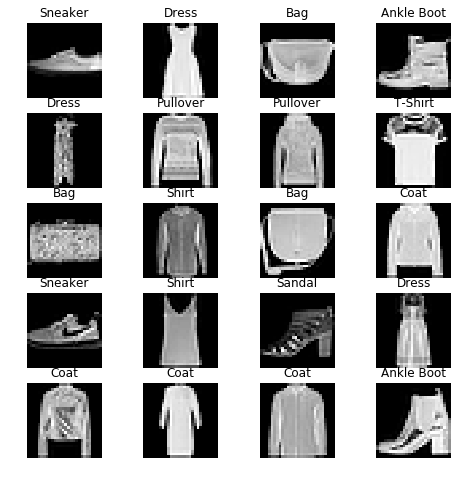

In [39]:
import matplotlib.pyplot as plt

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(dataset));
    img = dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[dataset[img_xy][1].item()])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [42]:
import torch.nn as nn
import torch.nn.functional as F

# define a neural network, convolutional neural network
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.dropout = nn.Dropout(p=0.5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32*4*4, 10)
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# instantiate the model
model = CNNModel()

In [44]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import CategoricalAccuracy, Loss

In [49]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [61]:
trainer = create_supervised_trainer(model, optimizer, criterion)

In [62]:
evaluator = create_supervised_evaluator(model,
                                            metrics={'accuracy': CategoricalAccuracy(),
                                                     'nll': Loss(F.nll_loss)},
                                            )


In [67]:
max_epochs = 100
validate_every = 10
checkpoint_every = 20
from tqdm import tqdm

In [76]:
trainer = create_supervised_trainer(model, optimizer, criterion)
evaluator = create_supervised_evaluator(model,
                                        metrics={
                                            'accuracy': CategoricalAccuracy(),
                                            'nll': Loss(criterion)
                                        })


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(validation_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['nll']))

trainer.run(train_loader, max_epochs=10)
pbar.close()

Validation Results - Epoch: 1  Avg accuracy: 0.89 Avg loss: 0.30
Validation Results - Epoch: 2  Avg accuracy: 0.90 Avg loss: 0.30
Validation Results - Epoch: 3  Avg accuracy: 0.90 Avg loss: 0.30
Validation Results - Epoch: 4  Avg accuracy: 0.90 Avg loss: 0.29
Validation Results - Epoch: 5  Avg accuracy: 0.89 Avg loss: 0.30
Validation Results - Epoch: 6  Avg accuracy: 0.90 Avg loss: 0.29
Validation Results - Epoch: 7  Avg accuracy: 0.90 Avg loss: 0.28
Validation Results - Epoch: 8  Avg accuracy: 0.90 Avg loss: 0.28
Validation Results - Epoch: 9  Avg accuracy: 0.90 Avg loss: 0.28


Validation Results - Epoch: 10  Avg accuracy: 0.90 Avg loss: 0.28


In [82]:
correct = 0
total = 0
for images, labels in test_loader:
    outputs = model(images)
    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)
                
    # Total number of labels
    total += labels.size(0)
                
    correct += (predicted == labels).sum()
            
accuracy = 100 * correct / total

In [84]:
print('Accuracy: {}% on the test set:'.format(accuracy))

Accuracy: 89% on the test set:
